In [1]:
from deap import tools, base, creator
import jax
from diversity_algorithms.controllers.fixed_structure_nn_flax import SimpleNeuralControllerFlax
import jax.numpy as jnp
from diversity_algorithms.environments.brax_env import EvaluationFunctor
from diversity_algorithms.algorithms.novelty_search import set_creator
creator.create("FitnessMax", base.Fitness, weights=(1.0,)*1)
import numpy as np
creator.create("Individual", np.ndarray, typecode="d", fitness=creator.FitnessMax)
set_creator(creator)


import numpy as np

import time
from diversity_algorithms.algorithms.utils import *
from diversity_algorithms.analysis.population_analysis import *
from diversity_algorithms.analysis.data_utils import *

from diversity_algorithms.algorithms.novelty_management import *

from diversity_algorithms.algorithms.jax_utils import *
from diversity_algorithms.environments.brax_env import create
from diversity_algorithms.environments.environments import registered_environments
from diversity_algorithms.analysis.coverage import *

from IPython.display import HTML
from brax.v1.io import html


%load_ext autoreload
%autoreload 2


# Set the parameters

In [29]:
pop_size = 8192
nb_gen = 10
env_name = "ant-uni" # "ant-uni" or "ant-omni"
episode_length = 300
seed = 0
nn_num_hidden_layers = 2
nn_num_per_hidden = 64

In [30]:
params = {"env_name": env_name,  # "ant-uni" or "ant-omni"
    	  "nb_gen": nb_gen,
		  "pop_size": pop_size,
		  "episode_length": episode_length,
		  "lambda_nov": int(0.06*pop_size),
		  "geno_type":"realarray", 
		  "variant":"NS", 
		  "eta_m":15.0,
		  "indpb":0.1,
		  "mutpb":1,
		  "cxpb":0,
		  "min":-1,
		  "max":1,
		  "k":15,
		  "add_strategy":"novel",
		  "verbosity":"none",
		  "lambda":1
	}

# Initialise the controller and the Evalution function

In [31]:
env_params = registered_environments[params["env_name"]]
random_key = jax.random.PRNGKey(seed)
controller = SimpleNeuralControllerFlax(87, 8, nn_num_hidden_layers, nn_num_per_hidden)
eval_functor = EvaluationFunctor(params["env_name"], 
                                 controller=controller, 
                                 episode_length=params["episode_length"],
                                 bd_function=env_params["bd_func"],
                                 output=env_params["eval_params"]["output"])

Environment set to ant-omni


# Toolbox Initilisation

In [32]:
toolbox = base.Toolbox()
toolbox.register("population", init_pop_controller, controller=controller)
toolbox.register("mutate", mutate, eta=params["eta_m"], min_val=params["min"], max_val=params["max"], indpb=params["indpb"])
toolbox.register("mate", cxBLend, alpha=params["indpb"])
toolbox.register("map_eval", eval_functor)
v=str(params["variant"])
variant=v.replace(",","")
if (variant == "NS"): 
	toolbox.register("select", selBest, fit_attr='novelty')
elif (variant == "Fit"):
	toolbox.register("select", selBest, fit_attr='fitness')
elif (variant == "Random"):
	toolbox.register("select", random.sample)
# elif (variant == "DistExplArea"):
# 	toolbox.register("select", selBest, fit_attr='dist_to_explored_area')
else:
	print("Variant not among the authorized variants (NS, Fit, Random), assuming multi-objective variant")
	toolbox.register("select", tools.selNSGA2)

# Initialisation run

In [34]:
best_ind = []
lambda_ = int(params["lambda"]*params["pop_size"])
population, random_key = toolbox.population(random_key, params["pop_size"])
fit, bd, random_key = toolbox.map_eval(jnp.asarray(population), random_key)

for ind, f, b in zip(population, fit, bd):
	ind.fit = f # fit is an attribute just used to store the fitness value
	ind.parent_bd = None
	ind.bd = b
	ind.id = generate_uuid()
	ind.parent_id = None

for ind in population:
	ind.am_parent=0

archive=updateNovelty(population,population,None,params)
isortednov=sorted(range(len(population)), key=lambda k: population[k].novelty, reverse=True)
varian=params["variant"].replace(",","")

if ("+" in variant):
	emo=True
else:
	emo=False
 
for i,ind in enumerate(population):
	ind.rank_novelty=isortednov.index(i)
	ind.dist_to_parent=0
	if (emo): 
		if (varian == "NS+Fit"):
			ind.fitness.values = (ind.novelty, ind.fit)
		elif (varian == "NS+BDDistP"):
			ind.fitness.values = (ind.novelty, 0)
		elif (varian == "NS+Fit+BDDistP"):
			ind.fitness.values = (ind.novelty, ind.fit, 0)
		else:
			print("WARNING: unknown variant: "+variant)
			ind.fitness.values=ind.fit
	else:
		ind.fitness.values=ind.fit
	# if it is not a multi-objective experiment, the select tool from DEAP 
	# has been configured above to take the right attribute into account
	# and the fitness.values is thus ignored


best_ind.append(selBest(population, 1, fit_attr="fitness")[0])
gen=0

# Learning loop

In [35]:
for gen in range(1, params["nb_gen"] + 1):
	print("Generation %d" % gen)
	t = time.time()
	offspring, random_key = varOr(random_key, population, toolbox, lambda_, params["cxpb"], params["mutpb"])
	print("varOr time: ", time.time() - t)
 
	# Evaluate the individuals with an invalid fitness
	t=time.time()
	fit, bd, random_key = toolbox.map_eval(jnp.asarray(offspring), random_key)
	print("map_eval time: ", time.time() - t)

	for ind, f, b in zip(offspring, fit, bd):
		ind.fit = f
		ind.fitness.values = f
		ind.parent_bd = ind.bd
		ind.parent_id = ind.id
		ind.id = generate_uuid()
		ind.bd = b

	for ind in population:
		ind.am_parent=1

	for ind in offspring:
		ind.am_parent=0
		
	pq = population+offspring
	pop_for_novelty_estimation = pq
	t=time.time()
	archive = updateNovelty(pq, offspring, archive, params, pop_for_novelty_estimation)
	print("updateNovelty time: ", time.time() - t)
	
	# Compute the novelty rank
	nov = [ind.novelty for ind in pq]
	isortednov = np.argsort(nov)[::-1]
	rank = np.empty_like(isortednov)
	rank[isortednov] = np.arange(len(isortednov))
	
	for i,ind in enumerate(pq):
		ind.rank_novelty = rank[i]
		#print("Indiv #%d: novelty=%f rank=%d"%(i, ind.novelty, ind.rank_novelty))
		if (ind.parent_bd is None):
			ind.dist_to_parent=0
		else:
			ind.dist_to_parent=np.linalg.norm(np.asarray(ind.bd)-np.asarray(ind.parent_bd))
		if (emo):
			if (varian == "NS+Fit"):
				ind.fitness.values = (ind.novelty, ind.fit)
			elif (varian == "NS+BDDistP"):
				if (ind.parent_bd is None):
					bddistp=0
				else:
					bddistp=np.linalg.norm(np.asarray(ind.bd) - np.asarray(ind.parent_bd))
				ind.fitness.values = (ind.novelty, bddistp)
			elif (varian == "NS+Fit+BDDistP"):
				if (ind.parent_bd is None):
					bddistp=0
				else:
					bddistp=np.linalg.norm(np.asarray(ind.bd) - np.asarray(ind.parent_bd))
				ind.fitness.values = (ind.novelty, ind.fit, bddistp)
			else:
				print("WARNING: unknown variant: "+variant)
				ind.fitness.values=ind.fit
		else:
			ind.fitness.values=ind.fit
	if (verbosity(params)):
		print("Gen %d"%(gen))
	else:
		if(gen%100==0):
			print(" %d "%(gen), end='', flush=True)
		elif(gen%10==0):
			print("+", end='', flush=True)
		else:
			print(".", end='', flush=True)
	
	best_ind.append(selBest(population, 1, fit_attr="fitness")[0])
	# Select the next generation population
	if ("," in variant):
		population[:] = toolbox.select(offspring, params["pop_size"])		
	else:
		population[:] = toolbox.select(pq, params["pop_size"])		


Generation 1
.Generation 2
.Generation 3
.Generation 4
.Generation 5
.Generation 6
.Generation 7
.Generation 8
.Generation 9
.Generation 10
+Generation 11
.Generation 12
.

# Show the best individual found

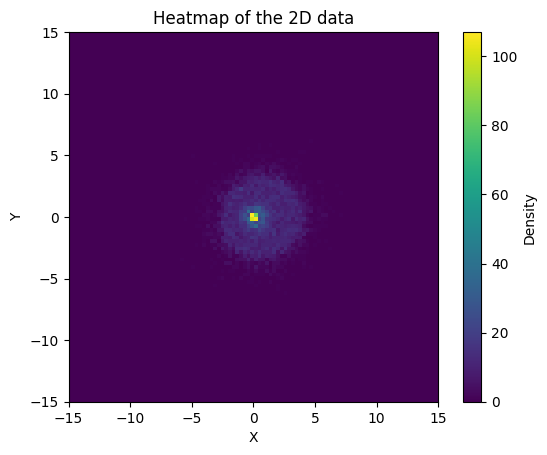

0.0825

In [38]:
data = load_archive(archive.all_bd)
if env_name == "ant_omni":
    coverageMap2d(data, -15, 15, 100, True)
else:
    coverageMap4d(data, 0, 1, 10, True)

In [39]:
best = selBest(best_ind, 1, fit_attr="fitness")[0]
print(best.fitness, best.bd)
best = controller.array_to_dict(best)

(95.73834991455078,) [0.08154319 0.03917944]


In [40]:
env = create("ant-uni", episode_length=300)
state = jax.jit(env.reset)(random_key)

In [41]:
jit_step = jax.jit(env.step)
jit_inf = jax.jit(controller.predict)

In [42]:
rollout = []
while not state.done:
    rollout.append(state)
    action = jit_inf(best, state.obs)
    state = jit_step(state, action)

In [43]:
HTML(html.render(env.sys, [s.qp for s in rollout]))